In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten





In [27]:
df = pd.read_csv("/content/Final_Dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

features = ['Dhaka AQI', 'co', 'go3', 'pan', 'c3h8', 'so2',
            'pm1_combined', 'pm2p5_combined', 'pm10_combined',
            'q', 't', 'r', 'u', 'v']
data = df[features].copy()

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_np = np.array(data_scaled)


In [28]:
def create_sequences(data, input_len=7, output_len=5):
    X, Y, fut_cov = [], [], []
    for i in range(len(data) - input_len - output_len):
        past = data[i:i+input_len]
        future = data[i+input_len:i+input_len+output_len]
        fut_covariates = future[:, 10:14]  # t, r, u, v
        X.append(past)
        Y.append(future[:, 0])  # AQI
        fut_cov.append(fut_covariates)
    return np.array(X), np.array(Y), np.array(fut_cov)

X_seq, Y_seq, F_seq = create_sequences(data_np)
X_train, X_test, Y_train, Y_test, F_train, F_test = train_test_split(
    X_seq, Y_seq, F_seq, test_size=0.2, random_state=42)


In [29]:
past_input = Input(shape=(7, 14), name="past_input")
future_cov_input = Input(shape=(5, 4), name="future_cov")

x = LSTM(64, return_sequences=False)(past_input)
fut_flat = Flatten()(future_cov_input)
x = Concatenate()([x, fut_flat])
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(5,activation='linear')(x)

model = Model(inputs=[past_input, future_cov_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_input          │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_cov          │ (None, 5, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     20,224 │ past_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ future_cov[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 84)        │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      5,440 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │        165 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,909 (109.02 KB)

 Trainable params: 27,909 (109.02 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    [X_train, F_train], Y_train,
    validation_data=([X_test, F_test], Y_test),
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0530 - mae: 0.1672 - val_loss: 0.0154 - val_mae: 0.0901
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0168 - mae: 0.0919 - val_loss: 0.0163 - val_mae: 0.0876
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - mae: 0.0826 - val_loss: 0.0143 - val_mae: 0.0841
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145 - mae: 0.0831 - val_loss: 0.0139 - val_mae: 0.0833
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - mae: 0.0801 - val_loss: 0.0142 - val_mae: 0.0863
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135 - mae: 0.0809 - val_loss: 0.0138 - val_mae: 0.0798
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0147 - mae: 0.0814 - val_loss: 0.0135 - val_mae: 0.0800
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0128 - mae: 0.0776 - val_loss: 0.0139 - val_mae: 0.0854
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0128 - ma

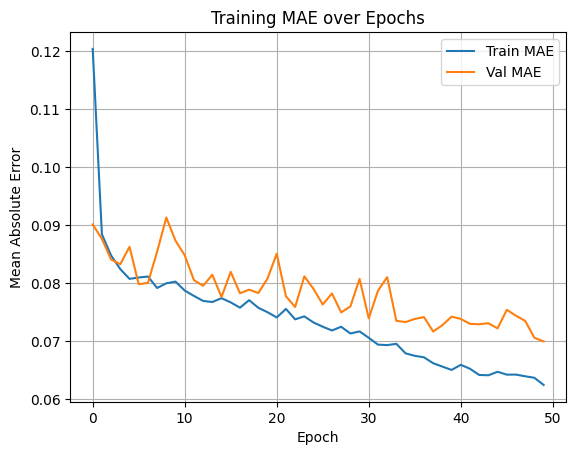

In [31]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Training MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
api_key = "3abeaeaa5c38500c81c8cb3a5c2c6a05"
lat, lon = 23.75, 90.32
url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"

response = requests.get(url)
forecast_data = response.json()

weather_records = []
for entry in forecast_data['list']:
    dt = datetime.fromtimestamp(entry['dt'])
    temp = entry['main']['temp']
    humidity = entry['main']['humidity']
    wind_speed = entry['wind']['speed']
    wind_deg = entry['wind']['deg']
    wind_u = -wind_speed * np.sin(np.radians(wind_deg))
    wind_v = -wind_speed * np.cos(np.radians(wind_deg))
    weather_records.append({
        'datetime': dt,
        't': temp + 273.15,
        'r': humidity,
        'u': wind_u,
        'v': wind_v
    })

forecast_df = pd.DataFrame(weather_records)
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
forecast_df.set_index('datetime', inplace=True)
noon_forecast = forecast_df[forecast_df.index.hour == 12].copy().reset_index(drop=True)
forecast_input = noon_forecast[['t', 'r', 'u', 'v']].values[:5].reshape(1, 5, 4)


In [33]:
forecast_df

,t,r,u,v
datetime,,,,
2025-07-29 06:00:00,302.18,79,-3.934488e+00,4.369692
2025-07-29 09:00:00,303.22,74,-3.425780e+00,5.275238
2025-07-29 12:00:00,303.13,75,-2.989272e+00,3.691443
2025-07-29 15:00:00,300.28,88,2.401065e+00,6.254989
2025-07-29 18:00:00,300.02,88,-1.776384e-01,5.086899
2025-07-29 21:00:00,299.64,89,-2.794811e+00,3.215063
2025-07-30 00:00:00,299.76,87,-2.946233e+00,3.159448
2025-07-30 03:00:00,300.26,85,-3.541760e+00,4.220905
2025-07-30 06:00:00,301.95,80,-2.476150e+00,6.128685


In [34]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os

# Load the Excel file
file_path = "/content/INFERENCE_date_only.csv.xlsx"
df = pd.read_excel(file_path)

# Rename columns to match training dataset
rename_map = {
    'pm1': 'pm1_combined',
    'pm2.5': 'pm2p5_combined',
    'pm10': 'pm10_combined'
}
df.rename(columns=rename_map, inplace=True)

# Ensure date is parsed and set as index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)

# Select the same features as in training
features = ['Dhaka AQI', 'co', 'go3', 'pan', 'c3h8', 'so2',
            'pm1_combined', 'pm2p5_combined', 'pm10_combined',
            'q', 't', 'r', 'u', 'v']
inference_data = df[features].copy()

# Load scaler from training dataset - simulate by fitting here (in real usage, use saved scaler)
scaler = MinMaxScaler()
inference_scaled = scaler.fit_transform(inference_data)
inference_np = np.array(inference_scaled)

# Extract last 7 days as model input (7, 14)
X_input = inference_np[-7:].reshape(1, 7, 14)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Preprocessed Inference Input (X_input)", dataframe=pd.DataFrame(X_input[0], columns=features))


In [35]:
#X_input = X_seq[-1].reshape(1, 7, 14)
predicted_scaled = model.predict([X_input, forecast_input])


aqi_min, aqi_max = scaler.data_min_[0], scaler.data_max_[0]
predicted_aqi = predicted_scaled[0] *0.01* (aqi_max - aqi_min) + aqi_min


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


In [36]:
predicted_scaled

array([[66.380394, 33.71862 , 44.087177, 63.092674, 44.75598 ]],
      dtype=float32)

In [37]:
print("\n Predicted AQI for Next 5 Days:")
for i, val in enumerate(predicted_aqi):
    print(f"Day {i+1}: {val:.2f}")



 Predicted AQI for Next 5 Days:
Day 1: 105.92
Day 2: 97.10
Day 3: 99.90
Day 4: 105.04
Day 5: 100.08
